# Temporal Convolutional Network

In [11]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 98 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
darts 0.12.0 requires matplotlib>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
!pip install darts


     |████████████████████████████████| 253 kB 4.0 MB/s 
     |████████████████████████████████| 9.9 MB 23.7 MB/s 
     |████████████████████████████████| 790 kB 56.1 MB/s 
     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 62 kB 770 kB/s 
     |████████████████████████████████| 38.2 MB 25 kB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 9.8 MB 59.6 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 10.3 MB 60.1 MB/s 
     |████████████████████████████████| 1.4 MB 20.3 MB/s 
     |████████████████████████████████| 177 kB 67.1 MB/s 
     |████████████████████████████████| 2.0 MB 55.2 MB/s 
     |████████████████████████████████| 155 kB 56.5 MB/s 
     |████████████████████████████████| 374 kB 70.7 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 214 kB 72.5 MB/s 
  Created wheel for 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

In [15]:
data_address = 'data'
training = pd.read_csv(data_address +'/cfp_dataset_v1.csv', index_col=False)
training.drop(['Unnamed: 0', 'MIDUPT1138P2300058', 'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'DMIDT1138P2300058',  'DLONGT1138P2300058', 'UNIXDT', 'UUID'], axis=1, inplace=True)

In [17]:
training.columns

Index(['WELL_ID', 'DT', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058'],
      dtype='object')

In [20]:
only_1_bad = training[training['WELL_ID'] == 226003316].copy()


In [35]:
only_1_bad.DT

9990     2019-07-31 23:55:00
9991     2019-07-31 23:50:00
9992     2019-07-31 23:45:00
9993     2019-07-31 23:40:00
9994     2019-07-31 23:35:00
                ...         
19972    2019-06-27 07:00:00
19973    2019-06-27 06:55:00
19974    2019-06-27 06:50:00
19975    2019-06-27 06:45:00
19976    2019-06-27 06:40:00
Name: DT, Length: 9987, dtype: object

find when to split?

In [37]:
only_1_bad['DT'] = pd.to_datetime(only_1_bad['DT'] )

print(only_1_bad.DT.min()-
      only_1_bad.DT.max())

only_1_bad.DT.min() + (only_1_bad.DT.max() - only_1_bad.DT.min()) * 0.7

-35 days +06:45:00


Timestamp('2019-07-21 13:56:29.999999999')

In [87]:
series = TimeSeries.from_dataframe(only_1_bad, 'DT', fill_missing_dates=True, freq=None)


In [88]:
scaler = Scaler()
ts = scaler.fit_transform(series)  # scale the whole time series not caring about train/val split...
target = ts['DSHORTT1138P2300058']
# Create training and validation sets:
train, val = target.split_after(pd.Timestamp('2019-07-21 00:00:00'))

covariates = ts[['WELL_ID', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399']]

train_cov, val_cov = covariates.split_after(pd.Timestamp('2019-07-21 00:00:00'))

[2021-11-07 10:40:34,487] WARNING | darts.timeseries | Number of components is larger than 10 (17). Plotting only the first 10 components.


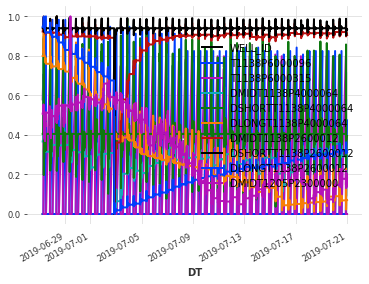

In [89]:
train_cov.plot()

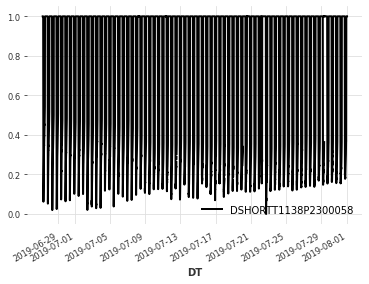

In [90]:
target.plot()

In [104]:
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape, mae


In [98]:
series_air = AirPassengersDataset().load()


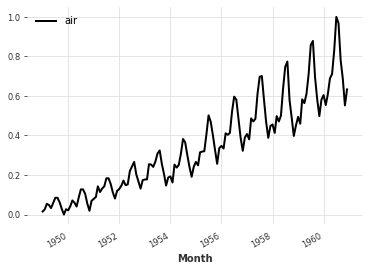

In [105]:
scaler_air = Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)

series_air_scaled.plot(label='air')
plt.legend();

In [106]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]


In [103]:
model_air = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=20, random_state=0)


In [107]:
model_air.fit(train_air, verbose=True)


[2021-11-07 10:53:38,047] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2021-11-07 10:53:38,047] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2021-11-07 10:53:38,137] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-11-07 10:53:38,137] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
  5%|▌         | 1/20 [00:01<00:26,  1.42s/it]

 55%|█████▌    | 11/20 [00:15<00:14,  1.60s/it]

100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


In [116]:
pred = model_air.predict(n=36)


In [117]:
pred

<TimeSeries (DataArray) (time: 36, component: 1, sample: 1)>
array([[[0.47077488]],

       [[0.48273994]],

       [[0.52656831]],

       [[0.5030164 ]],

       [[0.53723833]],

       [[0.58865539]],

       [[0.65583528]],

       [[0.65323635]],

       [[0.66594649]],

       [[0.57589187]],

...

       [[0.60333051]],

       [[0.57320215]],

       [[0.60161959]],

       [[0.62808938]],

       [[0.67216724]],

       [[0.65828169]],

       [[0.76564941]],

       [[0.56949713]],

       [[0.67330629]],

       [[0.64563343]]])
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample

MAPE = 13.49%
MAE = 0.09%


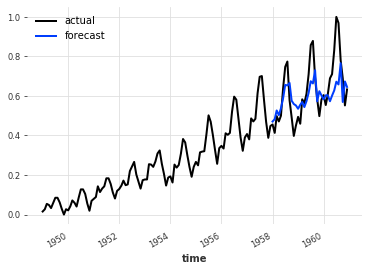

In [108]:
pred = model_air.predict(n=36)

series_air_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_air_scaled, pred)))
print('MAE = {:.2f}%'.format(mae(series_air_scaled, pred)))


In [97]:
print(target)

<TimeSeries (DataArray) (DT: 10000, component: 1, sample: 1)>
array([[[1.]],

       [[1.]],

       [[1.]],

       ...,

       [[1.]],

       [[1.]],

       [[1.]]])
Coordinates:
  * DT         (DT) datetime64[ns] 2019-06-27T06:40:00 ... 2019-07-31T23:55:00
  * component  (component) object 'DSHORTT1138P2300058'
Dimensions without coordinates: sample


In [111]:
model_target = NBEATSModel(input_chunk_length=50, output_chunk_length=1, n_epochs=3, random_state=0)


In [114]:
pred = model_target.predict(n=100)


In [115]:
pred

<TimeSeries (DataArray) (time: 100, component: 1, sample: 1)>
array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

...

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-07-21T00:05:00 ... 2019-07-21T08:20:00
  * component  (component) object 'DSHORTT1138P2300058'
Dimensions without coordinates: sample

In [ ]:
pred = model_target.predict(n=100)

# series_air_scaled.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_air_scaled, pred)))
print('MAE = {:.2f}%'.format(mae(series_air_scaled, pred)))


In [112]:
model_target.fit(train, verbose=True)


[2021-11-07 10:57:54,308] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6783 samples.
[2021-11-07 10:57:54,308] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6783 samples.
[2021-11-07 10:57:54,408] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-11-07 10:57:54,408] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
 33%|███▎      | 1/3 [01:08<02:17, 68.91s/it]

100%|██████████| 3/3 [03:28<00:00, 69.54s/it]


In [56]:
model_1pump = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=500,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [57]:
model_1pump.fit(series=train,
              past_covariates=train_cov,
              val_series=val,
              val_past_covariates=val_cov,
              verbose=True)

[2021-11-07 09:08:16,929] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6809 samples.
[2021-11-07 09:08:16,929] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6809 samples.
[2021-11-07 09:08:16,940] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 2
[2021-11-07 09:08:16,940] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 2
[2021-11-07 09:08:16,952] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-11-07 09:08:16,952] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
  0%|          | 1/500 [00:06<50:12,  6.04s/it]

  2%|▏         | 11/500 [00:51<40:17,  4.94s/it]

  4%|▍         | 21/500 [01:37<38:59,  4.88s/it]

  6%|▌         | 31/500 [02:22<38:34,  4.93s/it]

  8%|▊         | 41/500 [03:08<37:22,  4.89s/it]

 10%|█         | 51/500 [03:53<36:31,  4.88s/it]

 12%|█▏        | 61/500 [04:39<35:35,  4.87s/it]

 14%|█▍        | 71/500 [05:24<34:50,  4.87s/it]

 16%|█▌        | 81/500 [06:09<33:36,  4.81s/it]

 18%|█▊        | 91/500 [06:54<33:35,  4.93s/it]

 20%|██        | 101/500 [07:40<32:33,  4.90s/it]

 22%|██▏       | 111/500 [08:25<31:12,  4.81s/it]

 24%|██▍       | 121/500 [09:10<30:40,  4.86s/it]

 26%|██▌       | 131/500 [09:55<29:58,  4.88s/it]

 28%|██▊       | 141/500 [10:40<29:04,  4.86s/it]

 30%|███       | 151/500 [11:25<28:17,  4.86s/it]

 32%|███▏      | 161/500 [12:10<27:24,  4.85s/it]

 34%|███▍      | 171/500 [12:55<26:34,  4.85s/it]

 36%|███▌      | 181/500 [13:40<25:29,  4.79s/it]

 38%|███▊      | 191/500 [14:25<24:51,  4.83s/it]

 40%|████      | 201/500 [15:10<24:00,  4.82s/it]

 42%|████▏     | 211/500 [15:55<23:13,  4.82s/it]

 44%|████▍     | 221/500 [16:40<22:24,  4.82s/it]

 46%|████▌     | 231/500 [17:26<22:15,  4.96s/it]

 48%|████▊     | 241/500 [18:11<21:02,  4.87s/it]

 50%|█████     | 251/500 [18:57<20:25,  4.92s/it]

 52%|█████▏    | 261/500 [19:42<19:26,  4.88s/it]

 54%|█████▍    | 271/500 [20:28<18:32,  4.86s/it]

 56%|█████▌    | 281/500 [21:13<17:45,  4.86s/it]

 58%|█████▊    | 291/500 [21:58<16:56,  4.86s/it]

 60%|██████    | 301/500 [22:43<16:16,  4.91s/it]

 62%|██████▏   | 311/500 [23:28<15:07,  4.80s/it]

 64%|██████▍   | 321/500 [24:13<14:23,  4.82s/it]

 66%|██████▌   | 331/500 [24:58<13:36,  4.83s/it]

 68%|██████▊   | 341/500 [25:43<12:45,  4.82s/it]

 70%|███████   | 351/500 [26:28<12:03,  4.85s/it]

 72%|███████▏  | 361/500 [27:14<11:16,  4.86s/it]

 74%|███████▍  | 371/500 [27:59<10:31,  4.90s/it]

 76%|███████▌  | 381/500 [28:44<09:36,  4.84s/it]

 78%|███████▊  | 391/500 [29:29<08:51,  4.88s/it]

 80%|████████  | 401/500 [30:14<07:59,  4.85s/it]

 82%|████████▏ | 411/500 [31:00<07:12,  4.86s/it]

 84%|████████▍ | 421/500 [31:45<06:21,  4.83s/it]

 86%|████████▌ | 431/500 [32:30<05:38,  4.91s/it]

 88%|████████▊ | 441/500 [33:15<04:46,  4.86s/it]

 90%|█████████ | 451/500 [34:00<03:56,  4.82s/it]

 92%|█████████▏| 461/500 [34:45<03:07,  4.81s/it]

 94%|█████████▍| 471/500 [35:30<02:20,  4.84s/it]

 96%|█████████▌| 481/500 [36:14<01:31,  4.81s/it]

 98%|█████████▊| 491/500 [36:59<00:43,  4.87s/it]

100%|██████████| 500/500 [37:38<00:00,  4.52s/it]


In [68]:
backtest_one = model_1pump.historical_forecasts(series=val,
                                          past_covariates=val_cov,
                                          
                                          forecast_horizon=6,
                                          retrain=False,
                                          verbose=True)
backtest_one.plot()


100%|██████████| 1579/1579 [00:17<00:00, 92.11it/s]


In [71]:
model_1pump.predict(10)

<TimeSeries (DataArray) (time: 10, component: 1, sample: 1)>
array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-07-21T00:05:00 ... 2019-07-21T00:50:00
  * component  (component) object 'DSHORTT1138P2300058'
Dimensions without coordinates: sample

In [5]:
backtest = model_air.historical_forecasts(series=ts,
                                          past_covariates=month_series,
                                          start=0.7,
                                          forecast_horizon=6,
                                          retrain=False,
                                          verbose=True)



100%|██████████| 39/39 [00:00<00:00, 68.45it/s]


<TimeSeries (DataArray) (time: 2046, component: 1, sample: 1)>
array([[[nan]],

       [[nan]],

       [[nan]],

       ...,

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-07-13T21:35:00 ... 2019-07-21
  * component  (component) <U1 '0'
Dimensions without coordinates: sample

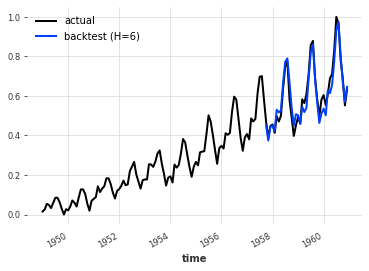

In [8]:
ts.plot(label='actual')

backtest.plot(label='backtest (H=6)')
plt.legend();

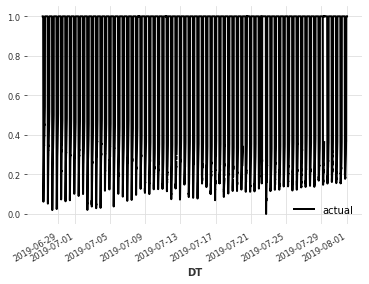

In [64]:
target.plot(label='actual')

# backtest.plot(label='backtest (H=6)')
plt.legend();

Не работает вариант все подать.

Попробуем для начала только таргет

In [92]:
model_one_target = TCNModel(
    input_chunk_length=100,
    output_chunk_length=2,
    n_epochs=2,
    dropout=0,
    dilation_base=2,
    weight_norm=True,
    kernel_size=3,
    num_filters=6,
    nr_epochs_val_period=1,
    random_state=0
)

In [93]:
model_one_target.fit(train, val_series=val, verbose=True)


[2021-11-07 10:41:46,488] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6732 samples.
[2021-11-07 10:41:46,488] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6732 samples.
[2021-11-07 10:41:46,498] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2021-11-07 10:41:46,498] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2021-11-07 10:41:46,511] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-11-07 10:41:46,511] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
 50%|█████     | 1/2 [00:05<00:05,  5.55s/it]

100%|██████████| 2/2 [00:11<00:00,  5.60s/it]

In [94]:
backtest_one_target = model_one_target.historical_forecasts(target,
                                             start=0.8,
                                             forecast_horizon=2,
                                             stride=1,
                                             retrain=False,
                                             verbose=True)



100%|██████████| 2000/2000 [00:23<00:00, 84.51it/s]


In [95]:
backtest_one_target

<TimeSeries (DataArray) (time: 2000, component: 1, sample: 1)>
array([[[nan]],

       [[nan]],

       [[nan]],

       ...,

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-07-25T01:20:00 ... 2019-07-31T23:55:00
  * component  (component) <U1 '0'
Dimensions without coordinates: sample

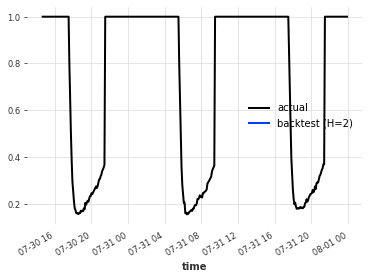

In [82]:
target[-400:].plot(label='actual')
backtest_one_target.plot(label='backtest (H=2)')
plt.legend();

In [80]:
backtest_one_target

<TimeSeries (DataArray) (time: 1500, component: 1, sample: 1)>
array([[[nan]],

       [[nan]],

       [[nan]],

       ...,

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-07-21T14:00:00 ... 2019-07-31T23:50:00
  * component  (component) <U1 '0'
Dimensions without coordinates: sample